Read the README file and have fun! - Antti

In [272]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils.training_utils import multi_gpu_model
from keras import utils as np_utils

from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For wider plots
plt.rcParams["figure.figsize"] = (20,6)

# Take my NVidia GPU into use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [425]:
# The data is from Physionet (https://www.physionet.org/physiobank/database/gaitndd/) 
# download it to the same folder as your notebook.

files = glob.glob("*.ts")
shuffle(files)

In [123]:
fdf = pd.DataFrame(files)

# Do note that I am using a binary classification only below, use use getClassification for all classes
fdf['classification']  = fdf[0].map(lambda x: getClassForHealthyOrNot(x))

# I will use a stratified shuffle split based on the individuals rather than samples
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1917)
for train_index, test_index in split.split(fdf, fdf['classification']):
    strat_train = fdf.loc[train_index]
    strat_test  = fdf.loc[test_index]
    
train_files = strat_train[0].values
test_files = strat_test[0].values

In [398]:
# Few helper functions for classification

def getClassForHealthyOrNot(filename):
    if (filename.find("control") >=0):
        return 0
    else:
        return 1

def getClassification(filename):
    if (filename.find("control") >=0):
        return 0
    elif (filename.find("als") >=0):
        return 1
    elif (filename.find("hunt") >=0):
        return 2
    elif (filename.find("park") >=0):
        return 3

def getClassificationString(classnro):
    if (classnro == 0):
        return ("control")
    elif (classnro == 1):
        return ("als")
    elif (classnro == 2):
        return ("huntington")
    elif (classnro == 3):
        return ("parkinson")


In [395]:
# Read and label individual file

def readGaitFile(f, classifier = getClassForHealthyOrNot):
    d = pd.read_csv(f, sep='\t')
    d["classification"] = classifier(f)
    d.columns =["elaps_time", 
                   "stride_left_int", "stride_right_int", 
                   "swing_left_int", "swing_right_int",
                   "swing_left_int_percentage", "swing_right_int_percentage", 
                   "stance_left_int", "stance_right_int",    
                   "stance_left_percentage", "stance_right_percentage", 
                   "left_support", "right_support", "classification"]
    return d

In [390]:
# Given a list of files, produce a dataframe

def produceDatasetFromFileList(files, classifier = getClassForHealthyOrNot):
    dd = pd.DataFrame()

    for f in files:
        d = readGaitFile(f, classifier)
        dd = pd.concat([dd, d], axis=0)

    dd = dd.drop("elaps_time", axis=1)
    return dd

In [411]:
# Produce RNN ready samples from one individual file. 
# Used to play with the classifier

def produceSamplesFromFile(filename, n_features, n_samples, scaler, classifier = getClassForHealthyOrNot):
    ds = produceDatasetFromFileList([filename])
    
    rnn_ready = series_to_supervised(data=ds, 
                                n_in=n_samples, 
                                n_out=1)
    train = rnn_ready.values
    n_obs = n_samples * (n_features + 1) # the +1 is the label we carry with the data
    feature_position = -1

    # split into input and outputs
    train_X, train_y = train[:, :n_obs], train[:, feature_position]

    # Scale the values for faster convergence
    train_X = scaler.transform(train_X)
    
    train_X = train_X.reshape((-1, n_spatial_samples, n_features+1))
    return train_X[:, :, 0:n_features], classifier(filename)


In [423]:
# Change from row formatted to time series. The following lines are from Dr. Jason Brownlee.

def series_to_supervised(data, n_in, n_out):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Concatenate everything
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

### Here we produce the data for our machine learning model. Using 12 features and 30 samples per classification.

In [418]:
# Construct the training and testing dataset
n_spatial_samples = 30
n_features = 12

reshaped_training = series_to_supervised(data=produceDatasetFromFileList(train_files, getClassForHealthyOrNot), 
                                n_in=n_spatial_samples, 
                                n_out=1)

reshaped_testing = series_to_supervised(data=produceDatasetFromFileList(test_files, getClassForHealthyOrNot), 
                                n_in=n_spatial_samples, 
                                n_out=1)

train = reshaped_training.values
test = reshaped_testing.values

n_obs = n_spatial_samples * (n_features + 1) # the +1 is the label we carry with the data
feature_position = -1

# Split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, feature_position]
test_X, test_y = test[:, :n_obs], test[:, feature_position]

# Scale the values
sc = StandardScaler()
sc.fit(train_X)
train_X = sc.transform(train_X)
test_X  = sc.transform(test_X)

# Shape for the RNN
train_X = train_X.reshape((-1, n_spatial_samples, n_features+1))
test_X  = test_X.reshape((-1, n_spatial_samples, n_features+1))
t_train_X = train_X[:, :, 0:n_features]
t_test_X  = test_X[:, :, 0:n_features]

print(train_X.shape, len(train_X), train_y.shape, test_X.shape, test_y.shape)

(12063, 30, 13) 12063 (12063,) (2973, 30, 13) (2973,)


In [164]:
# Distinguishing healthy control subjects from the unhealthy

model_pc = Sequential()
model_pc.add(LSTM(20, dropout=0.5, 
                  return_sequences=True, 
                  input_shape=(t_train_X.shape[1], t_train_X.shape[2])))

model_pc.add(LSTM(8, dropout=0.5))
model_pc.add(Dense(2, kernel_initializer='glorot_uniform', activation='sigmoid'))

model_pc.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_acc', patience=10, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./model/model_gait_healthynot_v1", 
                             monitor='val_acc', verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

y_binary_train = np_utils.to_categorical(train_y)
y_binary_test  = np_utils.to_categorical(test_y)

# fit network
history = model_pc.fit(t_train_X, y_binary_train, epochs=20, batch_size=24, 
                    validation_data=(t_test_X, y_binary_test), verbose=2, 
                    shuffle=True,
                    callbacks=[early_stopping, checkpoint])


Train on 12063 samples, validate on 2973 samples
Epoch 1/20
 - 25s - loss: 0.4635 - acc: 0.7692 - val_loss: 0.6490 - val_acc: 0.6011
Epoch 2/20
 - 21s - loss: 0.3861 - acc: 0.8121 - val_loss: 0.5753 - val_acc: 0.6608
Epoch 3/20
 - 21s - loss: 0.3559 - acc: 0.8302 - val_loss: 0.6326 - val_acc: 0.6874
Epoch 4/20
 - 21s - loss: 0.3376 - acc: 0.8387 - val_loss: 0.5629 - val_acc: 0.7257
Epoch 5/20
 - 21s - loss: 0.3171 - acc: 0.8514 - val_loss: 0.5442 - val_acc: 0.7287
Epoch 6/20
 - 21s - loss: 0.2999 - acc: 0.8560 - val_loss: 0.4865 - val_acc: 0.7681
Epoch 7/20
 - 21s - loss: 0.2892 - acc: 0.8644 - val_loss: 0.4718 - val_acc: 0.8226
Epoch 8/20
 - 21s - loss: 0.2847 - acc: 0.8645 - val_loss: 0.4882 - val_acc: 0.8120
Epoch 9/20
 - 21s - loss: 0.2717 - acc: 0.8767 - val_loss: 0.4597 - val_acc: 0.8291
Epoch 10/20
 - 21s - loss: 0.2640 - acc: 0.8833 - val_loss: 0.4358 - val_acc: 0.8466
Epoch 11/20
 - 21s - loss: 0.2482 - acc: 0.8888 - val_loss: 0.5261 - val_acc: 0.7980
Epoch 12/20
 - 21s - loss

### So we got an accuracy of 86.24% on our best model that is overfitting a bit. However, since we build multiple samples from an individual file, lets see the results of the majority vote on the dataset.

In [414]:
LOAD_MODEL = False
correct = 0
incorrect = 0

if (LOAD_MODEL):
    model_pc = load_model("model/model_gait_healthynot_v1")
    
for f in test_files:
    data, label = produceSamplesFromFile(f, n_features=12, n_samples=30, scaler=sc,
                                         classifier=getClassForHealthyOrNot)
    predictions = model_pc.predict_classes(data)
    
    predict_distribution = pd.Series(predictions).value_counts()
    predictClass = predict_distribution.idxmax()
    
    if (label == predictClass):
        prediction_text = "correct"
        correct += 1
    else:
        prediction_text = "incorrect"
        incorrect += 1

    output = ("prediction was %s for %s") % (prediction_text, os.path.basename(f))
    print(output)

print(("Number of samples: %d, %d correct, %d incorrect.") % 
    (correct+incorrect, correct, incorrect))

prediction was correct for hunt16.ts
prediction was correct for control16.ts
prediction was correct for hunt1.ts
prediction was correct for park11.ts
prediction was incorrect for hunt8.ts
prediction was correct for als13.ts
prediction was correct for hunt15.ts
prediction was correct for als5.ts
prediction was correct for control1.ts
prediction was correct for als6.ts
prediction was correct for hunt20.ts
prediction was correct for control6.ts
prediction was correct for hunt3.ts
Number of samples: 13, 12 correct, 1 incorrect.


### The 2973 samples reflect the 13 individuals. Where as the 12063 samples 51 individuals. We get 1 wrong in the testing set, and 4 on the training set. Lets see the strait data of the individuals and plot them out.

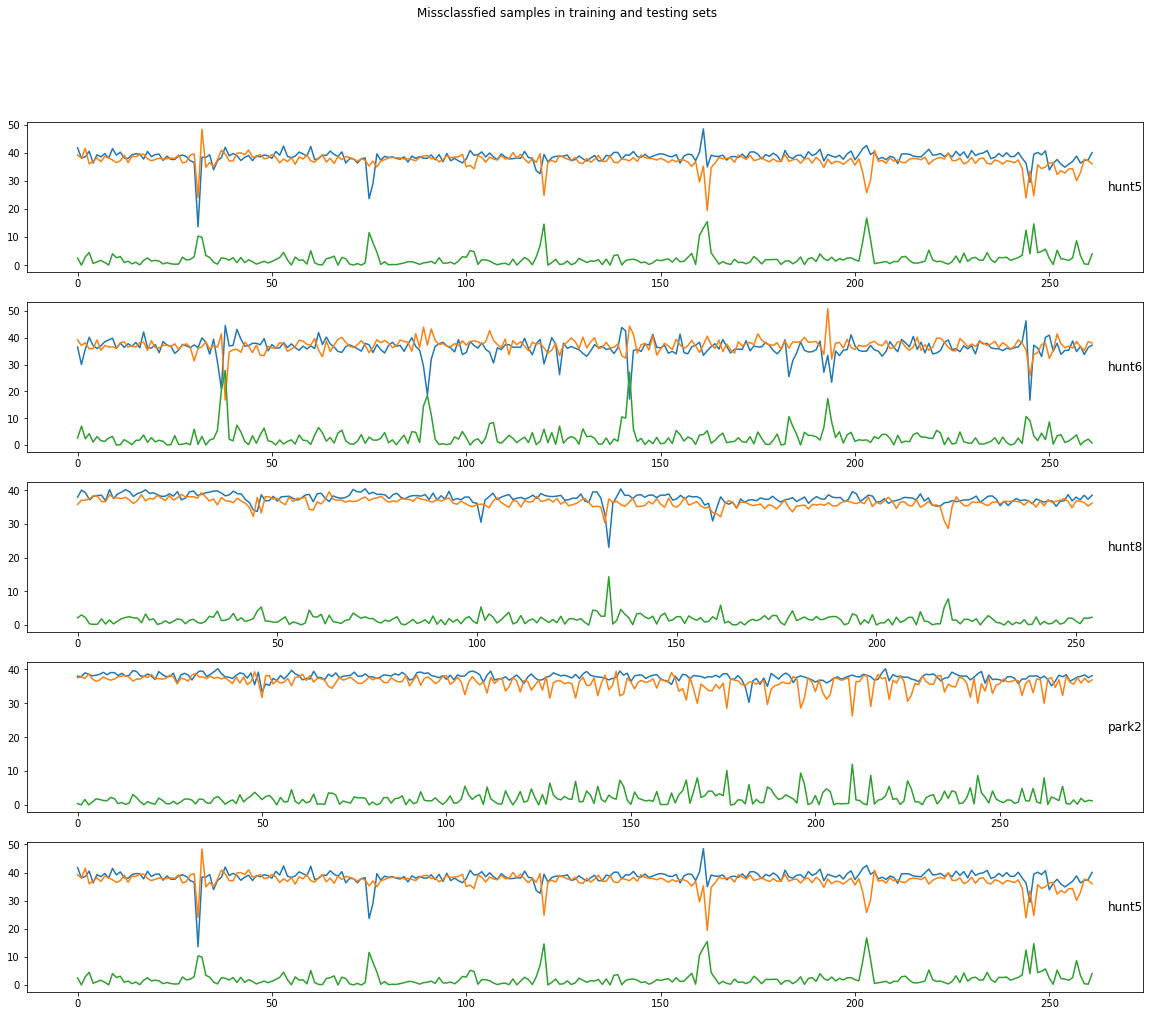

In [426]:
# The following samples got incorrectly classified
misslabeled = ["hunt5", "hunt6", "hunt8", "park2", "hunt5"]

plt.rcParams["figure.figsize"] = (20,16)

i = 1
plt.figure()
plt.suptitle('Missclassfied samples in training and testing sets')
for item in misslabeled:
    plt.subplot(len(misslabeled), 1, i)
    fname = "%s.ts" % (misslabeled[i-1])
    d1 = readGaitFile(fname, getClassification)
    plt.plot(d1['swing_left_int_percentage'])
    plt.plot(d1['swing_right_int_percentage'])
    plt.plot(abs(d1['swing_left_int_percentage'] - d1['swing_right_int_percentage']))
    plt.title(item, y=0.5, loc='right')
    i += 1
plt.show()

# Description of the subjects
### The misclassified Parkinson's was the least severe sample of Parkinson's disease, however the samples on the Huntington's were all medium severe.

In [384]:
personal_data = pd.read_csv("subject-description.txt", sep='\t')
personal_data['ret'] = pd.to_numeric(personal_data['Duration/Severity'], errors='coerce')
pdDF = personal_data.sort_values(by="ret", ascending=True).dropna()

In [386]:
pdDF[(pdDF['GROUP'] == 'park' ) | (pdDF['GROUP'] == 'hunt')]

,Unnamed: 0,GROUP,AGE(YRS),HEIGHT(meters),Weight(kg),gender,GaitSpeed(m/sec),Duration/Severity,ret
34,hunt19,hunt,59.0,1.78,58,f,0.98,1.0,1.0
38,park2,park,44.0,1.67,54,f,1.26,1.5,1.5
45,park9,park,68.0,1.92,84,m,1.05,1.5,1.5
42,park6,park,53.0,2.00,86,m,1.33,2.0,2.0
39,park3,park,80.0,1.81,77,m,0.98,2.0,2.0
33,hunt18,hunt,54.0,1.72,53,f,0.98,2.0,2.0
19,hunt4,hunt,47.0,1.88,64,f,1.4,2.0,2.0
22,hunt7,hunt,71.0,2.00,75,m,1.05,2.0,2.0
41,park5,park,75.0,1.92,91,m,1.05,2.0,2.0
51,park15,park,76.0,2.00,96,m,1.19,2.5,2.5


# Here is a classification model for all classes
### Please note you need to change classifier to use all four classes.

In [ ]:
# If you want to try out classifying all the four classes

model = Sequential()
model.add(LSTM(20, dropout=0.5, return_sequences=True,
                input_shape=(t_train_X.shape[1], t_train_X.shape[2])))
model.add(LSTM(10, dropout=0.5))
model.add(Dense(4, kernel_initializer='glorot_uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_acc', patience=8, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./model_gait_v3_3", 
                             monitor='val_acc', verbose=0,
                             save_best_only=True, 
                             save_weights_only=False, mode='auto', period=1)

y_binary_train = np_utils.to_categorical(train_y)
y_binary_test = np_utils.to_categorical(test_y)

history = model.fit(t_train_X, y_binary_train, epochs=30, batch_size=20, 
                    validation_data=(t_test_X, y_binary_test), verbose=2, 
                    shuffle=True,
                    callbacks=[early_stopping, checkpoint])